In [1]:
from JAX.model_JAX import MLP_Jax
from JAX.environment_JAX import WaterTank_Jax
import optax
import orbax
import jax
from jax import random
import jax.numpy as jnp
from flax.training import orbax_utils
import time
from plotting import plot_history
import pandas as pd
%load_ext autoreload
%autoreload 2

# Learn

In [5]:
from JAX.learn_JAX import learn_JAX
from params import influx_params, env_params, model_params, run_params, start_params, optimizer_params

total_time = time.time()

# Environment
water_tank = WaterTank_Jax(env_params, influx_params, model_params)
take_step = water_tank.get_take_step()

# starting conditions
level = jnp.array([[start_params["level"]]])
curr_time = jnp.array([[start_params["time"]]])
influx = water_tank.get_influx_func()(jnp.array([[start_params["time"]]]))
state = jnp.concatenate((level, influx), axis = 1)

# ML
model = MLP_Jax(model_params["layer_sizes"][1:]) # have to remove the first element
weight_params = model.init(random.PRNGKey(42), state)

# optimizer
lr_scheduler = optax.cosine_decay_schedule(0.001, 50000)
optimizer = optax.adam(learning_rate= lr_scheduler) # optimizer_params["learning_rate"])
opt_state = optimizer.init(weight_params)

weight_params, timer = learn_JAX("JAX test" ,weight_params, level, curr_time, optimizer, opt_state, take_step)

# Save parameters
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(weight_params)
orbax_checkpointer.save('model_params_JAX', weight_params, save_args=save_args, force = True)

total_time = time.time() - total_time

cummulative loss,▄█▂██████▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
level,▆█▃██████▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▅█▃██████▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_abs_gradient,▁▁▁▁▁▁▁▁▁▁▄▂▂▃▃▃▃▃▃▃▃▄▄▅▆▇▇█████████████
max_abs_weight,▁▁▁▁▁▁▁▁▁▁▃▄▄▄▄▄▅▅▅▆▆▇▇▇████████████████
max_abs_weight_change,▂▁█▁▁▁▁▁▁▆▆▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_abs_gradient,▁▁▁▁▁▁▁▁▁▁▅▃▃▄▄▄▄▄▄▄▄▅▅▆▆▇▇█████████████
mean_abs_weight,▁▁▁▁▁▁▂▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇████████████████
mean_abs_weight_change,▄▁█▁▁▁▁▁▁▅▆▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
outflux percentage,▁▁▁▁▁▁▁▁▁▁▆▂█▃▃▃▃▃▃▃▃▃▃▃▃▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅
cummulative loss,1.06502


# Timer

In [3]:
df1 = pd.DataFrame({key: timer[key] for key in ["log", "epoch"]})
df2 = pd.DataFrame({key: timer[key] for key in timer if key not in ["log", "epoch"]})

print(total_time)
display(df1.describe())
df2.describe()

24.774948358535767


,log,epoch
count,100.000000,100.000000
mean,0.011282,0.124243
std,0.040710,0.097331
min,0.006488,0.109590
25%,0.006959,0.111750
50%,0.007166,0.112878
75%,0.007379,0.116437
max,0.414284,1.086876


,step,take_step,parameter_update
count,50000.000000,50000.000000,50000.000000
mean,0.000224,0.000079,0.000105
std,0.001816,0.000935,0.000782
min,0.000193,0.000066,0.000091
25%,0.000200,0.000069,0.000095
50%,0.000205,0.000070,0.000097
75%,0.000217,0.000074,0.000103
max,0.382565,0.169517,0.174848


# One Episode

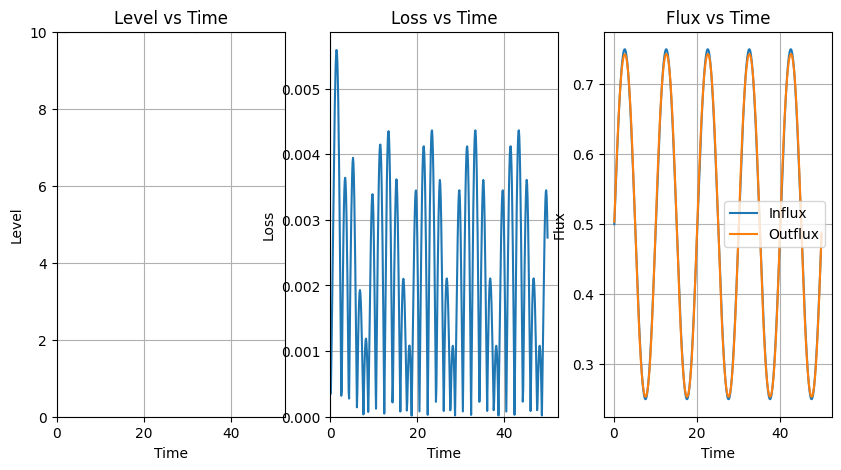

In [4]:
from params import influx_params, env_params, model_params, run_params, start_params, optimizer_params

# Environment
water_tank = WaterTank_Jax(env_params, influx_params, model_params)
take_step = water_tank.get_take_step()

# starting conditions
level = jnp.array([[start_params["level"]]])
curr_time = jnp.array([[start_params["time"]]])
state = jnp.concatenate((level, curr_time), axis = 1)

# load parameters
# weight_params = orbax_checkpointer.restore('model_params_JAX')
                           
for step in range(run_params["num_steps"]):
    buf = take_step(weight_params, level, curr_time)
    (reward, aux_data), grads = buf
    level, curr_time, influx, outflux_percentage = aux_data
    water_tank.store_step(level, curr_time, reward, influx, outflux_percentage)

plot_history(*water_tank.get_history())